## About dataset

- **InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description:** Product (item) name. Nominal.
- **Quantity:** The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice:** Unit price. Numeric, Product price per unit in sterling.
- **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country:** Country name. Nominal, the name of the country where each customer resides.


## Import necessary libraries


In [258]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
sns.set_style('darkgrid')

In [121]:
# We'll use this function for outliers removing
def quantile(x: pd.Series, whis: int = 1.5):
    Q1, Q3 = np.quantile(x, [0.25, 0.75])
    IQR = Q3 - Q1
    maximum = Q3 + whis * IQR
    minimum = Q1 - whis * IQR
    return (maximum, minimum)

## Loading the dataset


In [122]:
df = pd.read_csv("./data.csv")

## Understanding the dataset


In [123]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [124]:
df.shape

(541909, 8)

In [125]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [127]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [128]:
df.describe(include=object)

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,United Kingdom
freq,1114,2313,2369,1114,495478


In [129]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

## Drop duplicated rows


In [130]:
df.duplicated().sum()

5268

In [131]:
df = df.drop_duplicates(keep="first")

In [132]:
df.duplicated().sum()

0

## De-noise the dataset


In [133]:
len(df[df["UnitPrice"] <= 0])

2512

In [134]:
# Fist let's check the values of UnitPrice
# UnitPrice shouldn't be equal or less than zero
df = df[df["UnitPrice"] > 0] 

In [135]:
df["StockCode"].apply(len).value_counts()

StockCode
5     480270
6      50514
4       1271
3        707
1        701
7        388
2        143
12        68
9         47
8         20
Name: count, dtype: int64

In [136]:
df[df["StockCode"].apply(len) == 6]["Description"].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER    2353
JUMBO BAG RED RETROSPOT               2153
WOODEN FRAME ANTIQUE WHITE             995
JUMBO  BAG BAROQUE BLACK WHITE         957
JUMBO BAG STRAWBERRY                   839
                                      ... 
PEARL & SHELL 42"NECKL. IVORY            1
PINK FLOCK PHOTO FRAME                   1
BAROQUE BUTTERFLY EARRINGS RED           1
ORANGE/FUSCHIA STONES NECKLACE           1
OCEAN SCENT CANDLE JEWELLED DRAWER       1
Name: count, Length: 938, dtype: int64

In [137]:
df[df["StockCode"].apply(len) == 5]["Description"].value_counts()

Description
REGENCY CAKESTAND 3 TIER              2187
PARTY BUNTING                         1719
LUNCH BAG RED RETROSPOT               1625
ASSORTED COLOUR BIRD ORNAMENT         1488
SET OF 3 CAKE TINS PANTRY DESIGN      1465
                                      ... 
BIG POLKADOT MUG                         1
PORCELAIN HANGING BELL SMALL             1
SET OF 4 KNICK KNACK TINS  DOILEY        1
SET OF THREE VINTAGE GIFT WRAPS          1
WHITE WITH METAL BAG CHARM               1
Name: count, Length: 3080, dtype: int64

In [138]:
df[df["StockCode"].apply(len).isin([1, 2, 3, 4])]["Description"].value_counts()
# It doesn't look like a product so we'll remove it

Description
POSTAGE                       1252
DOTCOM POSTAGE                 707
Manual                         561
CARRIAGE                       143
Discount                        77
SAMPLES                         62
CRUK Commission                 16
PADS TO MATCH ALL CUSHIONS       3
Adjust bad debt                  1
Name: count, dtype: int64

In [139]:
# From the dataset description StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
# So we'll remove any other
df = df[df["StockCode"].apply(len).isin([5, 6])]

In [140]:
# same StockCode and different description?
(df.groupby("StockCode")["Description"].nunique() > 1).sum()
# We have 220 let's fix them

220

In [141]:
df["Description"] = df.groupby("StockCode")["Description"].transform(
    lambda x: pd.Series.mode(x)[0]
)

In [142]:
(df.groupby("StockCode")["Description"].nunique() > 1).sum()

0

In [143]:
# InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
# And from the dataset we noticed that canceled Invoice has negative quantity
canceled = df["InvoiceNo"].str.startswith("C")
df[canceled].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [144]:
# df = df[~canceled] # remove canceled order
# We don't want to remove canceled orders now, because we'll use them to identify customers who made purchases and returned them.
# If a customer falls into this category, we will remove them later.

In [145]:
# sns.boxplot(
#     df,
#     x="Quantity",
#     whis=5
# )

In [146]:
# sns.kdeplot(df, x="Quantity",fill=True)
# plt.xlim(-500,1500)

In [147]:
# # Remove outliers by quantile
# maximum, minimum = quantile(df["Quantity"],whis=2)
# print(maximum, minimum)
# # df = df[(df["Quantity"] > minimum) & (df["Quantity"] < maximum)]

## Handling missing values


In [148]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     131424
Country             0
dtype: int64

In [149]:
# We have a lot of data and there's no suitable way to fill the customer id so we'll drop all rows with null CustomerID
df = df[~df["CustomerID"].isna()]

In [150]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Feature extraction


In [151]:
# InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
# And from the dataset we noticed that canceled Invoice has negative quantity
canceled = df["InvoiceNo"].str.startswith("C")

In [152]:
df["Canceled"] = canceled

In [153]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["CustomerID"] = df["CustomerID"].apply(int)

In [154]:
df["TotalSpending"] = df["Quantity"] * df["UnitPrice"]

In [155]:
max_date = df["InvoiceDate"].max()


def get_recency(x: pd.Series):

    return (max_date - x.max()).days


customer_data = (
    df.groupby(["CustomerID"])
    .agg(
        {
            # "InvoiceNo": "count",
            "Canceled": lambda x: np.sum(~x) - np.sum(x),
            "TotalSpending": "sum",
            "Quantity": "mean",
            "InvoiceDate": get_recency,
            "Country": pd.Series.mode,
        }
    )
    .reset_index()
)


customer_data.columns = [
    "CustomerID",
    "OrderFrequency",
    # "CanceledFrequency",
    "TotalSpending",
    "AverageBasketSize",
    "Recency",
    "Country",
]
customer_data.head()

,CustomerID,OrderFrequency,TotalSpending,AverageBasketSize,Recency,Country
0,12346,0,0.00,0.000000,325,United Kingdom
1,12347,182,4310.00,13.505495,1,Iceland
2,12348,27,1437.24,86.370370,74,Finland
3,12349,72,1457.55,8.750000,18,Italy
4,12350,16,294.40,12.250000,309,Norway


OrderFrequency shouldn't be less than or equal zero

In [156]:
customer_data[customer_data["OrderFrequency"] <= 0]["CustomerID"].count()

49

In [157]:
customer_data = customer_data[customer_data["OrderFrequency"] > 0]

In [158]:
customer_data[customer_data["OrderFrequency"] <= 0]["CustomerID"].count()

0

Total spedning should't be less than or equall zero

In [159]:
customer_data[customer_data["TotalSpending"] <= 0]["CustomerID"].count()

1

In [160]:
customer_data = customer_data[customer_data["TotalSpending"] > 0]

In [161]:
customer_data[customer_data["TotalSpending"] <= 0]["CustomerID"].count()

0

In [162]:
customer_data[customer_data["AverageBasketSize"] <= 0]

,CustomerID,OrderFrequency,TotalSpending,AverageBasketSize,Recency,Country


Check outliers

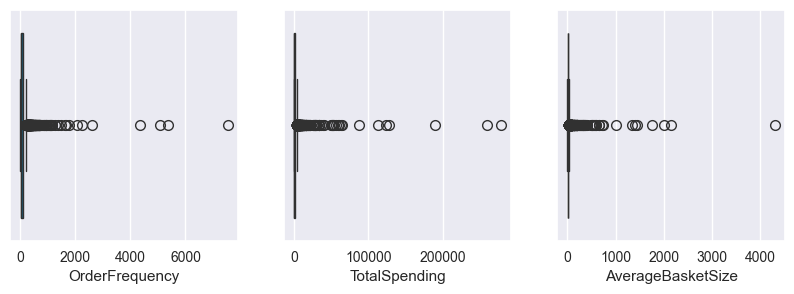

In [179]:
cols = customer_data.drop(["CustomerID", "Country", "Recency"], axis=1).columns
plt.figure(figsize=(10,3))
for i, col in enumerate(cols,1):
    plt.subplot(1,len(cols), i)
    sns.boxplot(customer_data, x=col)
plt.show()

In [180]:
for i in cols:
    print(i)
    upper_boundary, lower_boundary = quantile(customer_data[i])
    print(lower_boundary, upper_boundary)
    len_before = len(customer_data)
    len_after = len(
        customer_data[
            customer_data[i].between(lower_boundary, upper_boundary)
        ]
    )
    print("outliers percentage:", (1 - len_after / len_before))
    print(len_before - len_after)
    # It's ok to remove around 10% from the data because it's outliers
    customer_data = customer_data[
            customer_data[i].between(lower_boundary, upper_boundary)
        ]

OrderFrequency
-103.0 217.0
outliers percentage: 0.08766233766233766
378
TotalSpending
-1199.2875000000001 2734.0125000000003
outliers percentage: 0.08083375699034057
318
AverageBasketSize
-6.362202034286019 25.77450099170487
outliers percentage: 0.08573008849557517
310


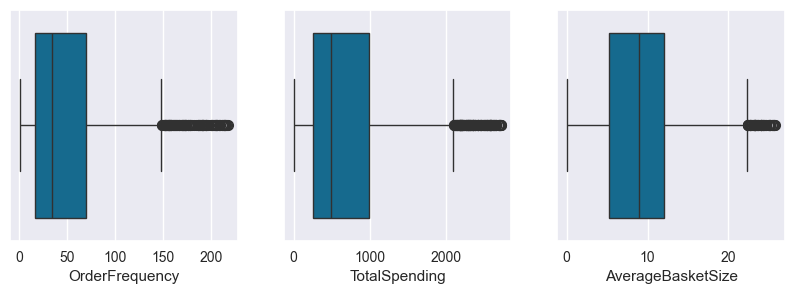

In [182]:
plt.figure(figsize=(10,3))
for i, col in enumerate(cols,1):
    plt.subplot(1,len(cols), i)
    sns.boxplot(customer_data, x=col)
plt.show()

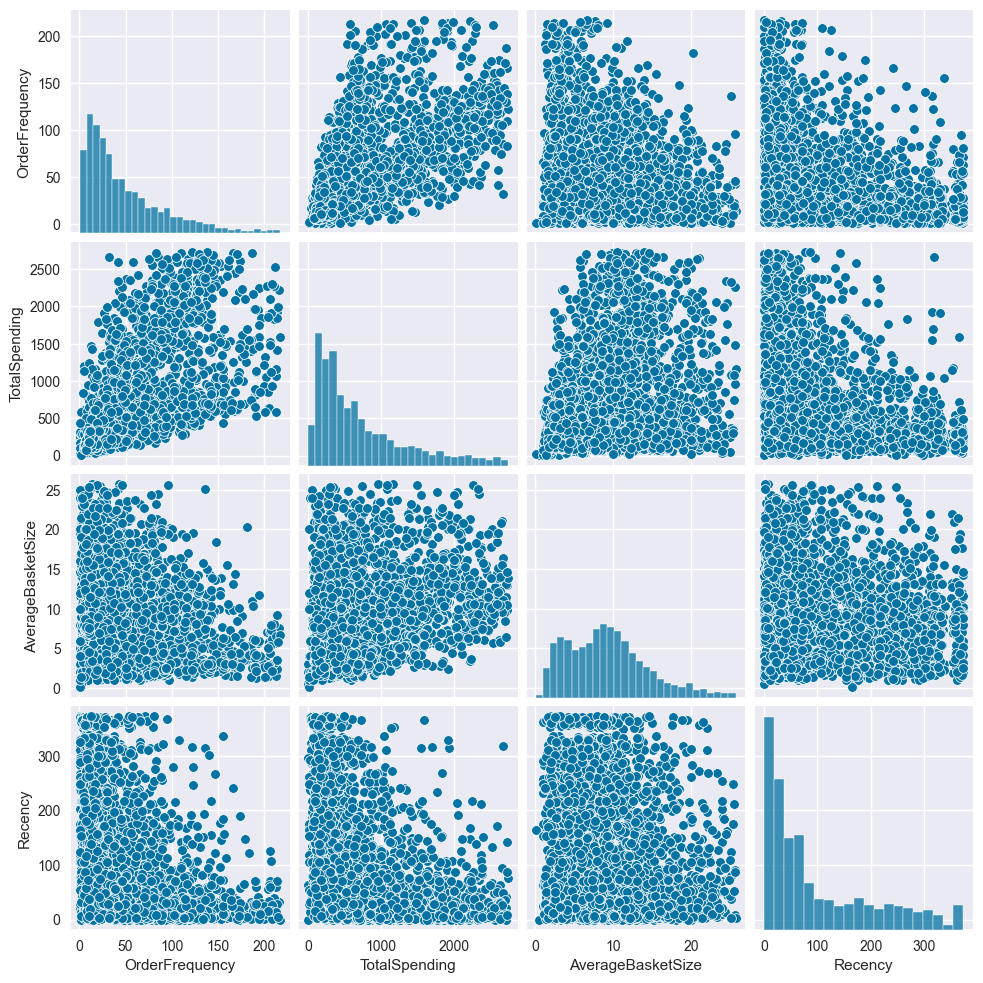

In [183]:
sns.pairplot(
    customer_data[
        [
            "OrderFrequency",
            "TotalSpending",
            "AverageBasketSize",
            "Recency",
        ]
    ]
);

In [52]:
# # Extract year, month, and day from "InvoiceDate" column
# def extract_year(x: datetime):
#     return x.year


# def extract_month(x: datetime):
#     return x.month


# def extract_day(x: datetime):
#     return x.day


# df["year"] = df["InvoiceDate"].apply(extract_year)
# df["month"] = df["InvoiceDate"].apply(extract_month)
# df["day"] = df["InvoiceDate"].apply(extract_day)
# df = df.drop("InvoiceDate",axis=1)

## Encoding categorical variables


In [184]:
customer_data["Country"] = LabelEncoder().fit_transform(
    customer_data["Country"].astype(str)
)

In [185]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3306 entries, 3 to 4361
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         3306 non-null   int64  
 1   OrderFrequency     3306 non-null   int64  
 2   TotalSpending      3306 non-null   float64
 3   AverageBasketSize  3306 non-null   float64
 4   Recency            3306 non-null   int64  
 5   Country            3306 non-null   int32  
dtypes: float64(2), int32(1), int64(3)
memory usage: 167.9 KB


## Scaling numerical features


In [186]:
# Scaling
scaled_customer_data = StandardScaler().fit_transform(
    customer_data.drop(["CustomerID"], axis=1)
)

## dimensionality reduction using PCA


In [187]:
pca = PCA()
x_pca = pca.fit_transform(customer_data.drop(["CustomerID"], axis=1))
print(
    "info from first pc0 and pc1:",
    pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1],
)
df_pca = pd.DataFrame(x_pca, columns=pca.get_feature_names_out())

info from first pc0 and pc1: 0.9973919700768171


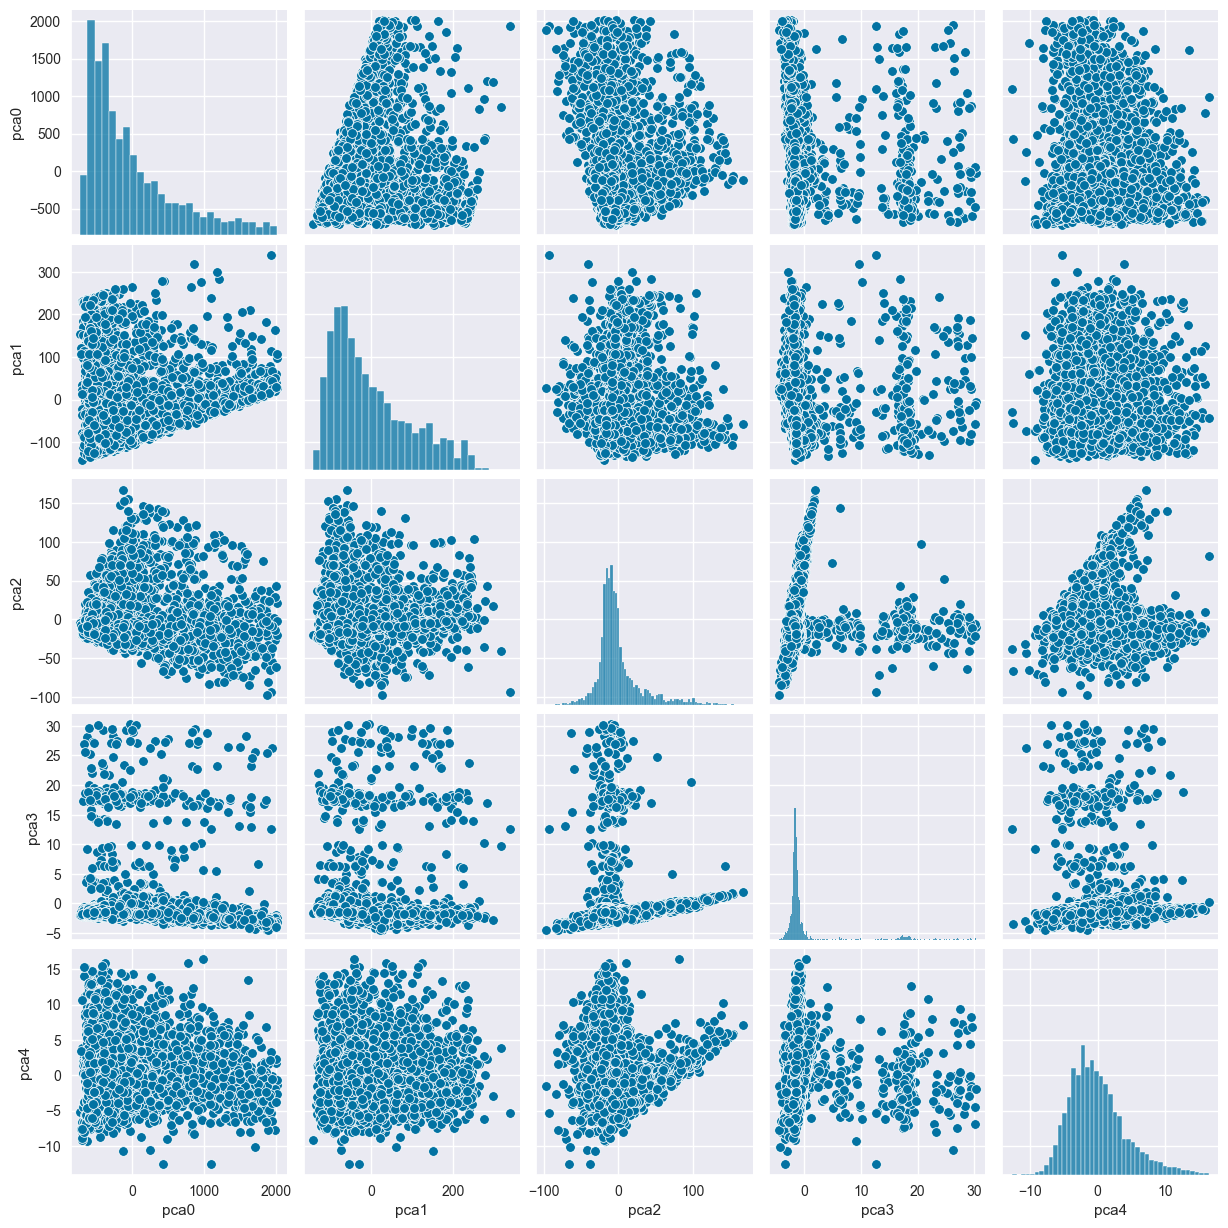

In [188]:
sns.pairplot(df_pca)

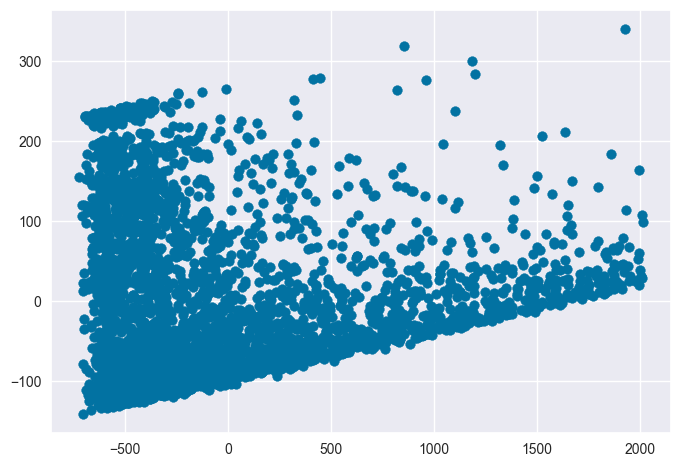

In [189]:
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1])
plt.show()

## Find the optimal number of clusters using the elbow method


In [190]:
inertias = []
for i in range(1, 10, 1):
    kmeans = KMeans(n_clusters=i, init="k-means++")
    kmeans.fit(x_pca)
    inertias.append(kmeans.inertia_)
    print(i, kmeans.inertia_)
    plt.show()

1 1304617882.223773
2 376504904.5893915
3 191344370.57441324
4 120793370.612387
5 88805862.15671962
6 74160934.40495317
7 60817971.37871954
8 49410347.0033223
9 43423130.5360603


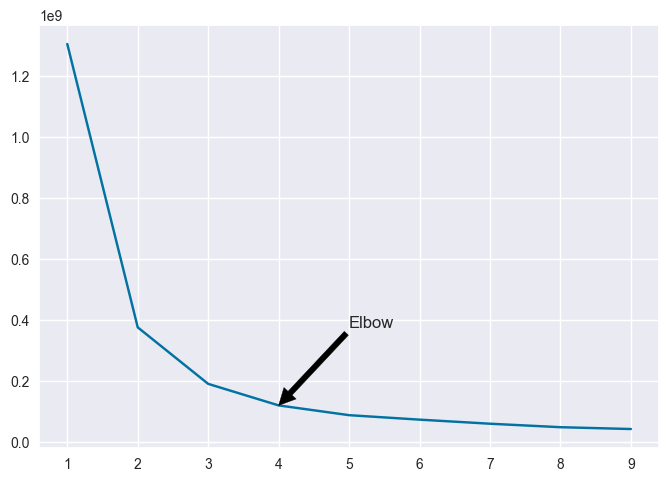

In [191]:
plt.plot(range(1, 10), inertias)
plt.xticks(range(1, 10))
plt.annotate(
    "Elbow",
    (4, inertias[3]),
    (5, inertias[1]),
    arrowprops={"color": "black"},
)
plt.show()

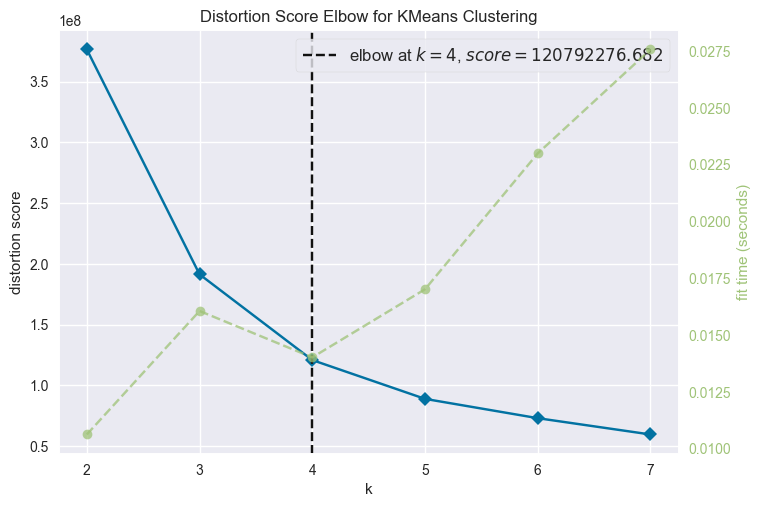

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [192]:
# In order to understand best performed cluster number K-Elbow Method is used
kelbow_visualizer = KElbowVisualizer( KMeans(n_init='auto'), k=(2,8))
kelbow_visualizer.fit(x_pca)
kelbow_visualizer.show()

## KMeans clustering


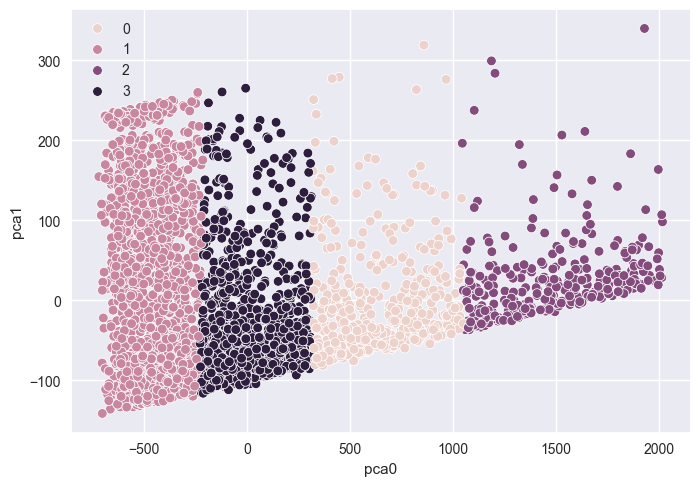

In [252]:
elbow = 4
kmeans = KMeans(n_clusters=elbow, init="k-means++")
sns.scatterplot(
    x=df_pca.iloc[:, 0],
    y=df_pca.iloc[:, 1],
    hue=kmeans.fit_predict(df_pca),
)
plt.show()

In [253]:
customer_data["cluster"] = kmeans.fit_predict(customer_data)

In [254]:
customer_data["cluster"].value_counts()

cluster
0    845
3    838
2    825
1    798
Name: count, dtype: int64

In [255]:
customer_data.head()

,CustomerID,OrderFrequency,TotalSpending,AverageBasketSize,Recency,Country,cluster
3,12349,72,1457.55,8.750000,18,16,0
4,12350,16,294.40,12.250000,309,22,0
5,12352,70,1265.41,5.511905,35,22,0
6,12353,4,89.00,5.000000,203,2,0
7,12354,58,1079.40,9.137931,231,27,0


## Profiling the clusters


In [256]:
cluster_profiling = customer_data.groupby("cluster").agg(
    {
        "CustomerID": "count",
        "TotalSpending": "mean",
        "OrderFrequency": "mean",
        "AverageBasketSize": "mean",
        "Recency": "mean",
    }
)
cluster_profiling

,CustomerID,TotalSpending,OrderFrequency,AverageBasketSize,Recency
cluster,,,,,
0,845,760.058982,46.164497,10.092278,100.654438
1,798,668.741855,51.209273,8.586295,99.218045
2,825,775.878255,49.416970,9.744755,99.390303
3,838,645.231897,49.133652,8.785012,101.873508


## Evaluation

In [257]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
# X, y = make_blobs(random_state=42)
print("silhouette_score:",silhouette_score(x_pca, kmeans.fit_predict(x_pca)))

silhouette_score: 0.5167060158981109


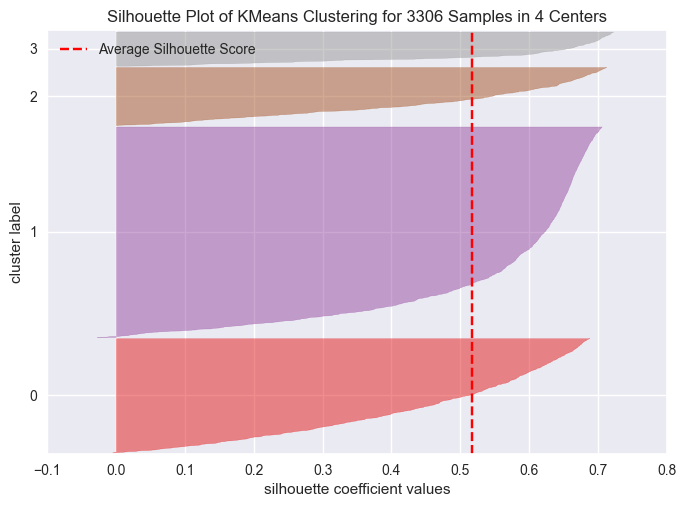

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3306 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [259]:
silhouette_visualizer = SilhouetteVisualizer(kmeans)
silhouette_visualizer.fit(x_pca)
silhouette_visualizer.show()

- The range of the Silhouette Score is from -1 to 1.
- A score of 1 indicates that the clusters are dense and well-separated from each other.
- A score of 0 indicates that the clusters are overlapping.
- A score close to -1 indicates that the samples might have been assigned to the wrong clusters.

Therefore, a Silhouette Score of 0.5 suggests that the clusters are reasonably well-separated and dense, but there may be some overlap between them.

## Personalization and Recommendations:

- Cluster 0 (845 Customers): These customers have a relatively high total spending, order frequency, average basket size, and recency.
  - Offer exclusive loyalty rewards or VIP programs to encourage continued spending and loyalty.

- Cluster 1 (798 Customers): These customers have slightly lower total spending compared to Cluster 0 but still have a high order frequency and average basket size.

  - Implement a referral program to encourage these customers to refer friends and family, thereby increasing their engagement and expanding the customer base.

- Cluster 2 (825 Customers): These customers have the highest total spending among the clusters, along with a moderate order frequency and average basket size.

  - Create VIP tiers with exclusive benefits such as early access to sales, dedicated customer support, or personalized gifts for their continued loyalty.

- Cluster 3 (838 Customers): These customers have slightly lower total spending and order frequency compared to other clusters, along with a relatively lower average basket size.
  - Implement a re-engagement campaign targeting these customers with personalized offers or incentives to encourage them to make additional purchases.